<a href="https://colab.research.google.com/github/joseandresv/Bayes-MCMC-wEmbeddings/blob/main/Wine_MCMC_Embeddings(PCA%2BMean).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding Wine Embeddings to MCMC process

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data = pd.read_csv("/content/gdrive/MyDrive/MCC/Métodos analíticos /wines_with_description.csv", delimiter=',')
data.head()

,judge,flight,wine,score,wine.amer,judge.amer,description
0,Jean-M Cardebat,white,A1,10.0,1,0,"After hand-picking, whole cluster pressing, an..."
1,Jean-M Cardebat,white,B1,13.0,1,0,This enticing Sauvignon Blanc offers a beautif...
2,Jean-M Cardebat,white,C1,14.0,0,0,Our 2013 Gewurztraminer displays classic rose ...
3,Jean-M Cardebat,white,D1,15.0,0,0,"""Light gold. A stunning bouquet offers powerfu..."
4,Jean-M Cardebat,white,E1,8.0,1,0,This is perhaps the most elegant Chardonnay ev...


## Creating Embeddings

### BERT calling and test

In [4]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [9]:
import torch
def get_bert_embeddings(text):
    # Tokenize and encode the text
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    with torch.no_grad():
        # Get the hidden states from BERT
        outputs = model(**inputs)
    # Get the embeddings from the last hidden state (or you can use other layers or combinations)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

In [10]:
data['embeddings'] = data['description'].apply(lambda x: get_bert_embeddings(x).squeeze().numpy())
data.head()

,judge,flight,wine,score,wine.amer,judge.amer,description,embeddings
0,Jean-M Cardebat,white,A1,10.0,1,0,"After hand-picking, whole cluster pressing, an...","[0.14796719, -0.020186903, -0.3261488, 0.12357..."
1,Jean-M Cardebat,white,B1,13.0,1,0,This enticing Sauvignon Blanc offers a beautif...,"[0.1402151, 0.0060550207, -0.14806426, -0.0974..."
2,Jean-M Cardebat,white,C1,14.0,0,0,Our 2013 Gewurztraminer displays classic rose ...,"[0.09549883, -0.00827736, -0.096210316, 0.0641..."
3,Jean-M Cardebat,white,D1,15.0,0,0,"""Light gold. A stunning bouquet offers powerfu...","[0.12561646, 0.07308795, -0.007863807, 0.09365..."
4,Jean-M Cardebat,white,E1,8.0,1,0,This is perhaps the most elegant Chardonnay ev...,"[-0.004704587, 0.100614175, -0.34878105, -0.13..."


Type verification

In [11]:
print(data.dtypes)
print(type(data['embeddings'][0]))  # Check the type of an element in the embeddings column

# Ensure all elements are NumPy arrays
data['embeddings'] = data['embeddings'].apply(lambda x: x if isinstance(x, np.ndarray) else x.numpy())

# Print the DataFrame to verify
print(data.head())

judge           object
flight          object
wine            object
score          float64
wine.amer        int64
judge.amer       int64
description     object
embeddings      object
dtype: object
<class 'numpy.ndarray'>
             judge flight wine  score  wine.amer  judge.amer  \
0  Jean-M Cardebat  white   A1   10.0          1           0   
1  Jean-M Cardebat  white   B1   13.0          1           0   
2  Jean-M Cardebat  white   C1   14.0          0           0   
3  Jean-M Cardebat  white   D1   15.0          0           0   
4  Jean-M Cardebat  white   E1    8.0          1           0   

                                         description  \
0  After hand-picking, whole cluster pressing, an...   
1  This enticing Sauvignon Blanc offers a beautif...   
2  Our 2013 Gewurztraminer displays classic rose ...   
3  "Light gold. A stunning bouquet offers powerfu...   
4  This is perhaps the most elegant Chardonnay ev...   

                                          embeddings  
0

### Finding cosine similarity of unique wine values.

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
unique_wines = data.drop_duplicates(subset=['wine'])

embeddings_list = unique_wines['embeddings'].tolist()
cosine_sim_matrix = cosine_similarity(embeddings_list)
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=unique_wines['wine'], columns=unique_wines['wine'])

print(cosine_sim_df)

wine        A1        B1        C1        D1        E1        F1        G1  \
wine                                                                         
A1    1.000000  0.855486  0.782133  0.769754  0.816182  0.784586  0.779992   
B1    0.855486  1.000000  0.730473  0.754525  0.811002  0.796984  0.802769   
C1    0.782133  0.730473  1.000000  0.735367  0.759904  0.757418  0.721659   
D1    0.769754  0.754525  0.735367  1.000000  0.699030  0.767392  0.644856   
E1    0.816182  0.811002  0.759904  0.699030  1.000000  0.754576  0.793362   
F1    0.784586  0.796984  0.757418  0.767392  0.754576  1.000000  0.684410   
G1    0.779992  0.802769  0.721659  0.644856  0.793362  0.684410  1.000000   
H1    0.845616  0.831506  0.822398  0.753240  0.805762  0.784278  0.804341   
I1    0.848677  0.804636  0.818006  0.774898  0.847656  0.763743  0.813663   
J1    0.789122  0.780970  0.734769  0.727590  0.704850  0.773750  0.715355   
A2    0.764619  0.745022  0.607262  0.664274  0.730567  0.750000

In [14]:
import seaborn as sns

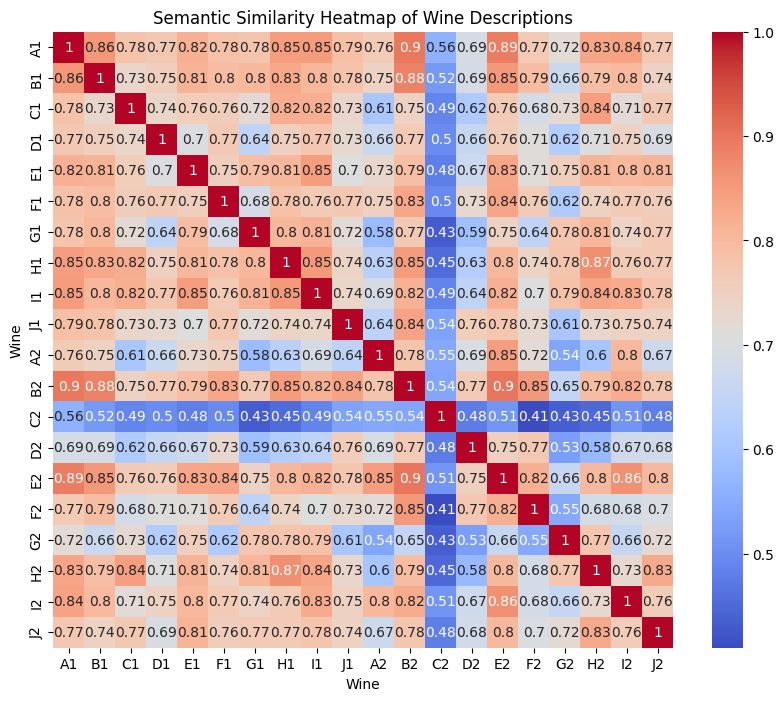

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Semantic Similarity Heatmap of Wine Descriptions')
plt.xlabel('Wine')
plt.ylabel('Wine')
plt.show()

### 2D PCA

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

<ipython-input-17-0e2628645ebd>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  light_colors = plt.cm.get_cmap('Pastel1', len(pca_df[pca_df['wine'].str.endswith('1')]))
<ipython-input-17-0e2628645ebd>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  dark_colors = plt.cm.get_cmap('Dark2', len(pca_df[pca_df['wine'].str.endswith('2')]))


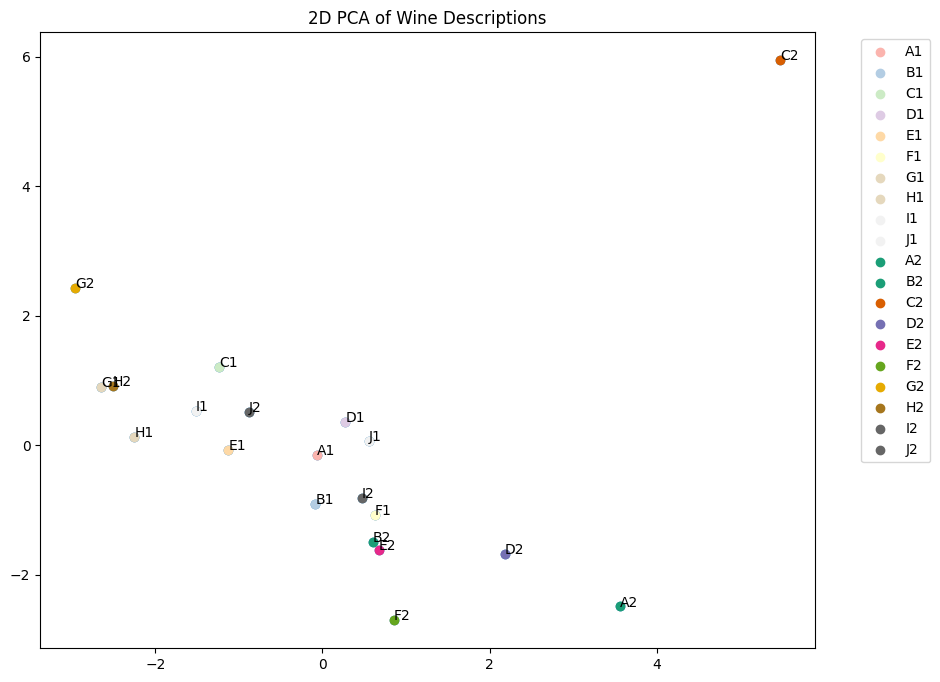

In [17]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_list)

pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['wine'] = unique_wines['wine'].values

plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'])

light_colors = plt.cm.get_cmap('Pastel1', len(pca_df[pca_df['wine'].str.endswith('1')]))
dark_colors = plt.cm.get_cmap('Dark2', len(pca_df[pca_df['wine'].str.endswith('2')]))

for i, wine in enumerate(pca_df['wine']):
    plt.annotate(wine, (pca_df['PCA1'][i], pca_df['PCA2'][i]))
    if wine.endswith('1'):
          color = light_colors(i % light_colors.N)
    else:
          color = dark_colors(i % dark_colors.N)
    plt.scatter(pca_df['PCA1'][i], pca_df['PCA2'][i], color=color, label=wine)

plt.title('2D PCA of Wine Descriptions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Starting Bayesian Workflow


### First try no embeddings

In [18]:
data['judge_num'] = pd.factorize(data['judge'])[0] + 1
data['wine_num'] = pd.factorize(data['wine'])[0] + 1

# Normalizing the score
mean_score = data['score'].mean()
std_score = data['score'].std()
data['score_est'] = (data['score'] - mean_score) / std_score

# Display the resulting DataFrame
data.head()

,judge,flight,wine,score,wine.amer,judge.amer,description,embeddings,judge_num,wine_num,score_est
0,Jean-M Cardebat,white,A1,10.0,1,0,"After hand-picking, whole cluster pressing, an...","[0.14796719, -0.020186903, -0.3261488, 0.12357...",1,1,-1.576604
1,Jean-M Cardebat,white,B1,13.0,1,0,This enticing Sauvignon Blanc offers a beautif...,"[0.1402151, 0.0060550207, -0.14806426, -0.0974...",1,2,-0.450458
2,Jean-M Cardebat,white,C1,14.0,0,0,Our 2013 Gewurztraminer displays classic rose ...,"[0.09549883, -0.00827736, -0.096210316, 0.0641...",1,3,-0.075076
3,Jean-M Cardebat,white,D1,15.0,0,0,"""Light gold. A stunning bouquet offers powerfu...","[0.12561646, 0.07308795, -0.007863807, 0.09365...",1,4,0.300306
4,Jean-M Cardebat,white,E1,8.0,1,0,This is perhaps the most elegant Chardonnay ev...,"[-0.004704587, 0.100614175, -0.34878105, -0.13...",1,5,-2.327368


In [19]:
n_judges = len(data['judge'].unique())
n_wines = len(data['wine'].unique())
n_scores = len(data)

wine_data_list = {
    'n_judges': n_judges,
    'n_wines': n_wines,
    'N': n_scores,
}

print(wine_data_list)

wine_data_list['S'] = data['score_est'].values
wine_data_list['wine'] = data['wine_num'].values
wine_data_list['judge'] = data['judge_num'].values

{'n_judges': 9, 'n_wines': 20, 'N': 180}


In [20]:
n_judges = wine_data_list['n_judges']
n_wines = wine_data_list['n_wines']
N = wine_data_list['N']
S = wine_data_list['S']
wine = wine_data_list['wine']
judge = wine_data_list['judge']

with pm.Model() as wine_model_1:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=n_wines)
    sigma = pm.Exponential('sigma', lam=1)

    # Transformed parameters
    media_score = Q[wine-1] # Python is 0-indexed

    # Model
    S_observed = pm.Normal('S', mu=media_score, sigma=sigma, observed=S)

In [21]:
with wine_model_1:
    trace = pm.sample(
        draws=2000,       # Number of sampling iterations
        tune=1000,        # Number of warmup iterations
        chains=4,         # Number of chains
        cores=4,          # Number of parallel chains
        target_accept=0.9 # Adjust acceptance rate to affect step size
    )

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [22]:
az.summary(trace, var_names=["Q", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Q[0],0.142,0.312,-0.474,0.701,0.003,0.003,15233.0,6070.0,1.0
Q[1],0.270,0.317,-0.330,0.855,0.003,0.003,14080.0,6547.0,1.0
Q[2],-0.124,0.314,-0.698,0.486,0.003,0.004,14296.0,5910.0,1.0
Q[3],0.289,0.314,-0.302,0.875,0.003,0.003,13501.0,5916.0,1.0
Q[4],0.086,0.314,-0.527,0.639,0.003,0.004,13870.0,5986.0,1.0
Q[5],-0.015,0.320,-0.592,0.609,0.003,0.004,15435.0,5707.0,1.0
Q[6],-0.107,0.316,-0.692,0.492,0.003,0.004,15365.0,5760.0,1.0
Q[7],-0.214,0.317,-0.805,0.391,0.003,0.003,12911.0,5936.0,1.0
Q[8],-0.138,0.320,-0.713,0.504,0.003,0.004,16179.0,6022.0,1.0
Q[9],-0.161,0.314,-0.750,0.424,0.003,0.003,14671.0,6170.0,1.0


In [23]:
summary_df = az.summary(trace, var_names=["Q", "sigma"])
summary_df = summary_df[~summary_df.index.str.contains("lp__")]
summary_df = summary_df[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat', 'ess_bulk', 'ess_tail']]
summary_df.columns = ['mean', 'sd', 'q3', 'q97', 'rhat', 'ess_bulk', 'ess_tail']
summary_df = summary_df.round(5)
print(summary_df)

        mean     sd     q3    q97  rhat  ess_bulk  ess_tail
Q[0]   0.142  0.312 -0.474  0.701   1.0   15233.0    6070.0
Q[1]   0.270  0.317 -0.330  0.855   1.0   14080.0    6547.0
Q[2]  -0.124  0.314 -0.698  0.486   1.0   14296.0    5910.0
Q[3]   0.289  0.314 -0.302  0.875   1.0   13501.0    5916.0
Q[4]   0.086  0.314 -0.527  0.639   1.0   13870.0    5986.0
Q[5]  -0.015  0.320 -0.592  0.609   1.0   15435.0    5707.0
Q[6]  -0.107  0.316 -0.692  0.492   1.0   15365.0    5760.0
Q[7]  -0.214  0.317 -0.805  0.391   1.0   12911.0    5936.0
Q[8]  -0.138  0.320 -0.713  0.504   1.0   16179.0    6022.0
Q[9]  -0.161  0.314 -0.750  0.424   1.0   14671.0    6170.0
Q[10]  0.097  0.309 -0.494  0.672   1.0   17929.0    6125.0
Q[11]  0.550  0.314 -0.056  1.128   1.0   15196.0    6018.0
Q[12] -0.369  0.313 -0.936  0.256   1.0   15535.0    5805.0
Q[13]  0.276  0.310 -0.277  0.894   1.0   16090.0    6660.0
Q[14]  0.125  0.315 -0.473  0.710   1.0   16282.0    6193.0
Q[15] -0.026  0.315 -0.629  0.553   1.0 

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


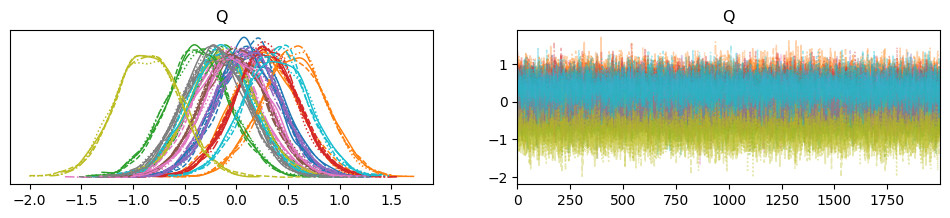

In [24]:
Q_chain1 = trace.posterior['Q']
az.plot_trace(Q_chain1)
plt.show()

### Adding Wine Description to model

Using the dot product of Q and description.T and the dot product of O and description.T to calculate media_score we combine the embeddings with the model parameters to appropriately influence the score predictions.

In [25]:
wine_data_list['description'] = np.vstack(data['embeddings'].values)

description = wine_data_list['description']

assert description.ndim == 2

embedding_size = description.shape[1]
print(f"The embedding size is: {embedding_size}")

The embedding size is: 768


In [26]:
wine_data_list['n_origins'] = len(data['wine.amer'].unique())
wine_data_list['origins'] = data['wine.amer'].values

n_origins = wine_data_list['n_origins']
origin = wine_data_list['origins']

**takes too long: 4860 s for 1005/12000 samples**


 8.38% [1005/12000 1:20:46<14:43:39 Sampling 4 chains, 0 divergences]

In [ ]:
with pm.Model() as wine_model_full_dotp_embeddings:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=(n_wines, embedding_size))
    O = pm.Normal('O', mu=0, sigma=1, shape=(n_origins, embedding_size))
    sigma = pm.Exponential('sigma', lam=1)

    # Transformed parameters with full embedding dot product
    media_score = pm.math.dot(Q[wine-1], description.T) + pm.math.dot(O[origin-1], description.T)

    # Model
    S_observed = pm.Normal('S', mu=media_score.sum(axis=1), sigma=sigma, observed=S)

    trace_full_dotp = pm.sample(
        draws=2000,       # Number of sampling iterations
        tune=1000,        # Number of warmup iterations
        chains=4,         # Number of chains
        cores=4,          # Number of parallel chains
        target_accept=0.9 # Adjust acceptance rate to affect step size
    )

    dif_origen = pm.Deterministic('dif_origen', O[0] - O[1])

In [ ]:
print(pm.summary(trace_full_dotp))


#### Using Mean Embeddings

In [46]:
mean_embeddings = np.vstack(data['embeddings'].values).mean(axis=1)

wine_data_list = {'mean_description': mean_embeddings}

mean_description = wine_data_list['mean_description']

In [70]:
with pm.Model() as wine_model_mean_embeddings:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=n_wines)
    O = pm.Normal('O', mu=0, sigma=1, shape=n_origins)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=mean_description.shape)  # Embedding coefficient
    sigma = pm.Exponential('sigma', lam=1)

    # Transformed parameters
    media_score = Q[wine-1] + O[origin-1] + beta * mean_description[wine-1]

    # Model
    S_observed = pm.Normal('S', mu=media_score, sigma=sigma, observed=S)

    dif_desc_mean_embeddings = pm.Deterministic('dif_desc_mean_embedding', beta[0] - beta[1])

    trace_mean_embeddings = pm.sample(
        draws=2000,       # Number of sampling iterations
        tune=1000,        # Number of warmup iterations
        chains=4,         # Number of chains
        cores=4,          # Number of parallel chains
        target_accept=0.9 # Adjust acceptance rate to affect step size
    )

In [65]:
az.summary(trace_mean_embeddings, var_names=["O", "Q","sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
O[0],-0.083,0.294,-0.645,0.461,0.008,0.005,1507.0,2956.0,1.0
O[1],0.105,0.346,-0.567,0.716,0.008,0.006,1970.0,3560.0,1.0
Q[0],0.216,0.410,-0.554,0.974,0.008,0.006,2747.0,4434.0,1.0
Q[1],0.346,0.407,-0.449,1.076,0.007,0.005,2984.0,5284.0,1.0
Q[2],-0.221,0.448,-1.022,0.661,0.008,0.006,3160.0,5087.0,1.0
Q[3],0.187,0.445,-0.608,1.072,0.008,0.006,3097.0,4560.0,1.0
Q[4],0.159,0.412,-0.647,0.891,0.008,0.005,2903.0,4485.0,1.0
Q[5],0.060,0.408,-0.677,0.858,0.008,0.005,2951.0,4734.0,1.0
Q[6],-0.031,0.412,-0.801,0.737,0.008,0.006,2797.0,4374.0,1.0
Q[7],-0.313,0.445,-1.164,0.502,0.008,0.006,3014.0,4711.0,1.0


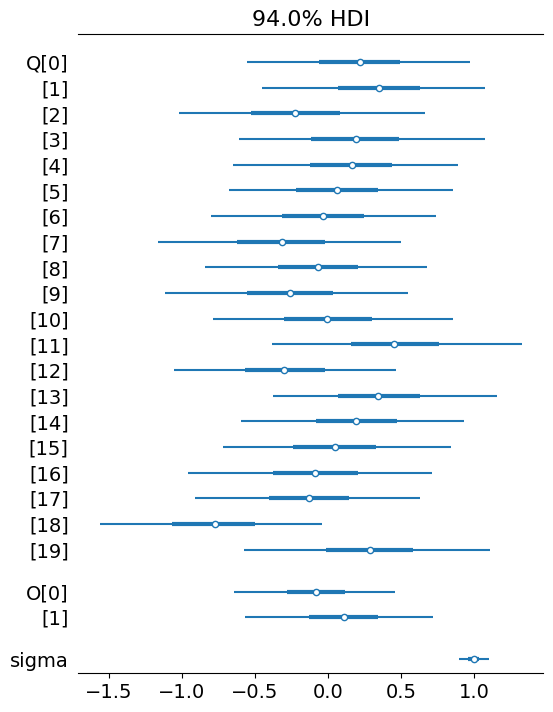

In [57]:
az.plot_forest(trace_mean_embeddings, var_names=("Q", "O", "sigma"), combined=True)
plt.show()

In [69]:
az.summary(trace_mean_embeddings, var_names=["dif_desc_mean_embedding"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dif_desc,-0.011,1.421,-2.678,2.722,0.012,0.018,14543.0,5546.0,1.0


#### Using PCA

In [43]:
pca = PCA(n_components=10)  # Adjust the number of components as needed
pca_embeddings = pca.fit_transform(np.vstack(data['embeddings'].values))

for i in range(pca_embeddings.shape[1]):
    data[f'pca_{i+1}'] = pca_embeddings[:, i]

pca_features = data[[f'pca_{i+1}' for i in range(pca_embeddings.shape[1])]].values

In [74]:
with pm.Model() as wine_model_pca:
    # Parameters
    Q = pm.Normal('Q', mu=0, sigma=1, shape=n_wines)
    O = pm.Normal('O', mu=0, sigma=1, shape=n_origins)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=pca_features.shape[1])  # PCA coefficients
    sigma = pm.Exponential('sigma', lam=1)

    # Transformed parameters
    media_score = Q[wine-1] + O[origin-1] + pm.math.dot(beta, pca_features[wine-1].T)

    # Model
    S_observed = pm.Normal('S', mu=media_score, sigma=sigma, observed=S)

    dif_desc_pca = pm.Deterministic('dif_desc_pca', beta[0] - beta[1])

    trace_pca = pm.sample(
        draws=2000,       # Number of sampling iterations
        tune=1000,        # Number of warmup iterations
        chains=4,         # Number of chains
        cores=4,          # Number of parallel chains
        target_accept=0.9 # Adjust acceptance rate to affect step size
    )

In [62]:
az.summary(trace_pca, var_names=["O", "Q", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
O[0],0.039,0.537,-0.965,1.040,0.008,0.006,4798.0,5878.0,1.0
O[1],0.161,0.559,-0.896,1.205,0.008,0.006,5081.0,5985.0,1.0
Q[0],0.150,0.705,-1.082,1.539,0.008,0.007,7393.0,6229.0,1.0
Q[1],-0.112,0.716,-1.391,1.288,0.008,0.007,7229.0,6129.0,1.0
Q[2],0.020,0.730,-1.346,1.417,0.009,0.008,6865.0,5991.0,1.0
Q[3],0.078,0.732,-1.337,1.418,0.007,0.008,9842.0,6374.0,1.0
Q[4],0.111,0.688,-1.208,1.377,0.008,0.007,7874.0,6487.0,1.0
Q[5],-0.003,0.720,-1.369,1.309,0.008,0.008,8300.0,6465.0,1.0
Q[6],0.026,0.770,-1.376,1.477,0.008,0.009,10332.0,6015.0,1.0
Q[7],0.011,0.756,-1.434,1.388,0.008,0.008,9456.0,6107.0,1.0


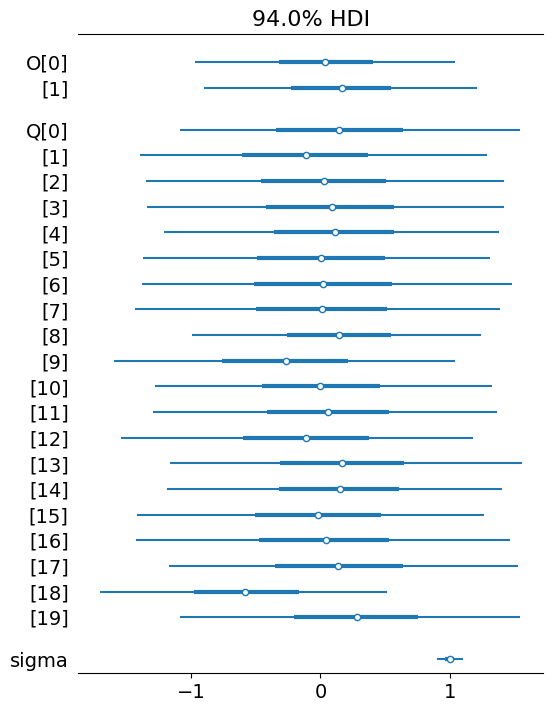

In [63]:
az.plot_forest(trace_pca, var_names=("O", "Q", "sigma"), combined=True)
plt.show()

In [75]:
az.summary(trace_pca, var_names=["dif_desc_pca"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dif_desc_pca,0.246,0.511,-0.728,1.18,0.006,0.005,8270.0,6243.0,1.0
